# Total mediation effects

Based on the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4287269/


In [1]:
%cd /mnt/home/zzhang/ceph/jemm

/mnt/ceph/users/zzhang/CHARM-SexDiff-Splicing/jemm


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5nn9wjub because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
data = pd.read_table("data-V9/mediation_analysis/first_mid.forCMA.withRaceEthnicity.txt")
data['viral_load'] = 40 - data['CTavg']

In [4]:
data.head()

,Unnamed: 0,sid,pid,final,Age,Sex,is_female,base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,...,sob,subj_fvr,taste,throat,num_symps,CTavg,days_since_infect,Race,Ethnicity,viral_load
0,0,20_0149-T42,149,First,19.0,M,0,-0.563513,0.144323,-0.089108,...,0.0,0.0,0.0,0.0,0.0,29.957500,0,White,Non-Hispanic,10.042500
1,1,20_0152-T53,152,First,19.0,M,0,-0.756253,0.070571,-0.205008,...,0.0,0.0,0.0,0.0,0.0,35.025000,0,White,Non-Hispanic,4.975000
2,2,20_0155-T42,155,First,22.0,M,0,-1.059343,0.325916,-0.360406,...,0.0,0.0,0.0,0.0,0.0,25.643333,0,White,Non-Hispanic,14.356667
3,3,20_0156-T42,156,First,22.0,M,0,-0.408753,0.458178,-0.379783,...,0.0,0.0,0.0,0.0,0.0,23.715000,0,Black,Non-Hispanic,16.285000
4,4,20_0157-T42,157,First,19.0,M,0,0.002407,0.249973,-0.218508,...,1.0,0.0,1.0,1.0,5.0,25.736667,0,Black,Non-Hispanic,14.263333


In [5]:
data.columns

Index(['Unnamed: 0', 'sid', 'pid', 'final', 'Age', 'Sex', 'is_female',
       'base_ISG_LV3', 'base_ISG_LV5', 'base_ISG_LV6', 'base_ISG_LV10',
       'base_ISG_LV3_prj', 'base_ISG_LV5_prj', 'base_ISG_LV6_prj',
       'base_ISG_LV10_prj', 'ISG_LV3_prj', 'ISG_LV5_prj', 'ISG_LV6_prj',
       'ISG_LV10_prj', 'PSI_CD45RBC', 'delta_PSI_CD45RBC', 'asymp', 'abd',
       'chill', 'cough', 'diarr', 'fatigue', 'fvr', 'headache', 'msk', 'nv',
       'rn_nose', 'sob', 'subj_fvr', 'taste', 'throat', 'num_symps', 'CTavg',
       'days_since_infect', 'Race', 'Ethnicity', 'viral_load'],
      dtype='object')

In [6]:
# data mangling of Race and Ethnicity
data['Race'] = data['Race'].str.replace('/', '_').str.replace('-','_')
race_df = pd.get_dummies(data['Race'], prefix="Race")
data['Ethnicity'] = data['Ethnicity'].str.replace('/', '_').str.replace('-','_')
eth_df = pd.get_dummies(data['Ethnicity'], prefix="Ethnicity")
data = pd.concat([data, race_df, eth_df], axis=1)
data.to_csv("data-V9/mediation_analysis/first_mid.forCMA.withRaceEthnicityDummies.txt", sep="\t")

In [7]:
def total_mediation_effects(rid, Y, a, Ms, Cs, data, use_first_only=False, outcome_family=None):
    # E[Y|a,m,c]
    if use_first_only:
        df = data.query('final=="First"')[[Y, a, ] + Ms + Cs]
    else:
        df = data[[Y, a, ] + Ms + Cs].copy()
    df['intercept'] = 1
    df.dropna(inplace=True)
    if outcome_family is not None:
        m1 = sm.GLM(df[Y], df[['intercept', a]+ Ms + Cs], family=outcome_family)
    else:
        m1 = sm.OLS(df[Y], df[['intercept', a]+ Ms + Cs])
    res1 = m1.fit()
    thetas = res1.summary2().tables[1].loc[Ms, 'Coef.'].to_dict()
    # E[Y|a,c]
    if outcome_family is not None:
        m2 = sm.GLM(df[Y], df[['intercept', a] + Cs], family=outcome_family)
    else:
        m2 = sm.OLS(df[Y], df[['intercept', a] + Cs])
    res2 = m2.fit()
    # E[m|a,c]
    betas = {}
    for M in Ms:
        m = sm.OLS(df[M], df[['intercept', a] + Cs])
        res = m.fit()
        betas[M] = res.summary2().tables[1].loc[a, 'Coef.']
    # indirect & direct effects
    ind_eff = sum([thetas[M]*betas[M] for M in Ms])
    dir_eff = res1.summary2().tables[1].loc[a, 'Coef.']
    tot_eff = res2.summary2().tables[1].loc[a, 'Coef.']
    prop = ind_eff/tot_eff
    return {
        'id': rid,
        'out': Y,
        'med': ','.join(Ms),
        "med_prop": prop, 
        "med_eff": ind_eff, 
        "dir_eff": dir_eff, 
        'tot_eff': tot_eff,
        'tot_pv': res2.summary2().tables[1].loc[a, 'P>|t|'] if outcome_family is None else res2.summary2().tables[1].loc[a, 'P>|z|'],
        #"m1": res1, 
        #"m2": res2, 
        "theta": thetas, 
        "beta": betas,
        'n_points': df.shape[0]
    }

In [8]:
res = []

In [9]:
res.append(total_mediation_effects(
    rid='viral_load.baseISG',
    Y='viral_load',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    use_first_only=True
))
#res[-1]

In [10]:
res.append(total_mediation_effects(
    rid='Num_Symps_over_Time.ISG',
    Y='num_symps',
    a='is_female',
    Ms=['ISG_LV3_prj','ISG_LV5_prj','ISG_LV6_prj','ISG_LV10_prj'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    outcome_family=sm.families.Poisson()
))
#res[-1]

In [11]:
res.append(total_mediation_effects(
    rid='Num_Symps.baseISG',
    Y='num_symps',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    use_first_only=True,
    outcome_family=sm.families.Poisson()
))
#res[-1]

In [12]:
res.append(total_mediation_effects(
    rid='delta_PSI_CD45RBC.baseISG',
    Y='delta_PSI_CD45RBC',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    use_first_only=False,
))
#res[-1]

In [13]:
res.append(total_mediation_effects(
    rid='Neutrophil.baseISG',
    Y='ISG_LV3_prj',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    use_first_only=False
))
#res[-1]

In [14]:
res.append(total_mediation_effects(
    rid='OtherISGs.baseISG',
    Y='ISG_LV5_prj',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
    use_first_only=False
))
#res[-1]

In [15]:
res.append(total_mediation_effects(
    rid='TypeII_ISG.baseISG',
    Y='ISG_LV6_prj',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
))
#res[-1]

In [16]:
res.append(total_mediation_effects(
    rid='TypeI_ISG.baseISG',
    Y='ISG_LV10_prj',
    a='is_female',
    Ms=['base_ISG_LV3','base_ISG_LV5','base_ISG_LV6','base_ISG_LV10'],
    Cs=['days_since_infect'] + race_df.columns.tolist() + eth_df.columns.tolist(),
    data=data,
))
#res[-1]

In [17]:
res_df = pd.DataFrame(res)
res_df.to_csv("data-V9/mediation_analysis/out.tot_med.txt", sep="\t", index=False)

In [18]:
res_df.sort_values('tot_pv')

,id,out,med,med_prop,med_eff,dir_eff,tot_eff,tot_pv,theta,beta,n_points
1,Num_Symps_over_Time.ISG,num_symps,"ISG_LV3_prj,ISG_LV5_prj,ISG_LV6_prj,ISG_LV10_prj",0.156197,0.066598,0.363951,0.426371,1.091036e-08,"{'ISG_LV3_prj': -0.14994742463760175, 'ISG_LV5...","{'ISG_LV3_prj': 0.09930807344283721, 'ISG_LV5_...",462
3,delta_PSI_CD45RBC.baseISG,delta_PSI_CD45RBC,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",0.326908,0.025382,0.052261,0.077643,9.796910e-05,"{'base_ISG_LV3': 0.0664253459028962, 'base_ISG...","{'base_ISG_LV3': 0.45796318318019547, 'base_IS...",358
6,TypeII_ISG.baseISG,ISG_LV6_prj,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",-0.208329,-0.051674,0.299717,0.248043,4.200301e-03,"{'base_ISG_LV3': -0.03750696280360368, 'base_I...","{'base_ISG_LV3': 0.4549033778537594, 'base_ISG...",359
4,Neutrophil.baseISG,ISG_LV3_prj,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",0.550506,0.100883,0.082372,0.183255,1.059078e-02,"{'base_ISG_LV3': 0.2772996500010223, 'base_ISG...","{'base_ISG_LV3': 0.4549033778537594, 'base_ISG...",359
7,TypeI_ISG.baseISG,ISG_LV10_prj,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",-0.109537,-0.019054,0.193009,0.173954,2.326785e-02,"{'base_ISG_LV3': 0.019586545447381868, 'base_I...","{'base_ISG_LV3': 0.4549033778537594, 'base_ISG...",359
2,Num_Symps.baseISG,num_symps,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",-1.103389,-0.409042,0.781510,0.370714,3.089240e-02,"{'base_ISG_LV3': -0.5616233120171509, 'base_IS...","{'base_ISG_LV3': 0.5434782296381321, 'base_ISG...",213
0,viral_load.baseISG,viral_load,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",0.269164,-0.608346,-1.651787,-2.260133,1.014217e-01,"{'base_ISG_LV3': -0.04194620222936636, 'base_I...","{'base_ISG_LV3': 0.5434782296381321, 'base_ISG...",213
5,OtherISGs.baseISG,ISG_LV5_prj,"base_ISG_LV3,base_ISG_LV5,base_ISG_LV6,base_IS...",-20.968112,-0.056313,0.058998,0.002686,9.234952e-01,"{'base_ISG_LV3': -0.02537302386078335, 'base_I...","{'base_ISG_LV3': 0.4549033778537594, 'base_ISG...",359


In [19]:
cma = pd.read_table("./data/mediation_analysis/out.cma.txt")
cma['outcome'] = [x.split('.')[0] for x in cma['model']]
cma['mediator'] = [x.split('.')[-1] for x in cma['model']]
cma['id'] = cma['outcome'].map({
    'viral_load': 'viral_load.baseISG',
    'delta_PSI_CD45RBC': 'delta_PSI_CD45RBC.baseISG',
    'Num_Symps_overTime': 'Num_Symps_over_Time.ISG',
    'Num_Symps': 'Num_Symps.baseISG',
    'ISG_LV3_prj': 'Neutrophil.baseISG',
    'ISG_LV5_prj': 'OtherISG.baseISG',
    'ISG_LV6_prj': 'TypeII_ISG.baseISG',
    'ISG_LV10_prj': 'TypeI_ISG.baseISG',
})

In [20]:
cma[['id', 'prop']].groupby('id').sum()

,prop
id,
Neutrophil.baseISG,0.463626
Num_Symps.baseISG,-1.263655
Num_Symps_over_Time.ISG,0.331585
OtherISG.baseISG,-0.830523
TypeII_ISG.baseISG,-0.333872
TypeI_ISG.baseISG,-0.382248
delta_PSI_CD45RBC.baseISG,0.479189
viral_load.baseISG,0.387009


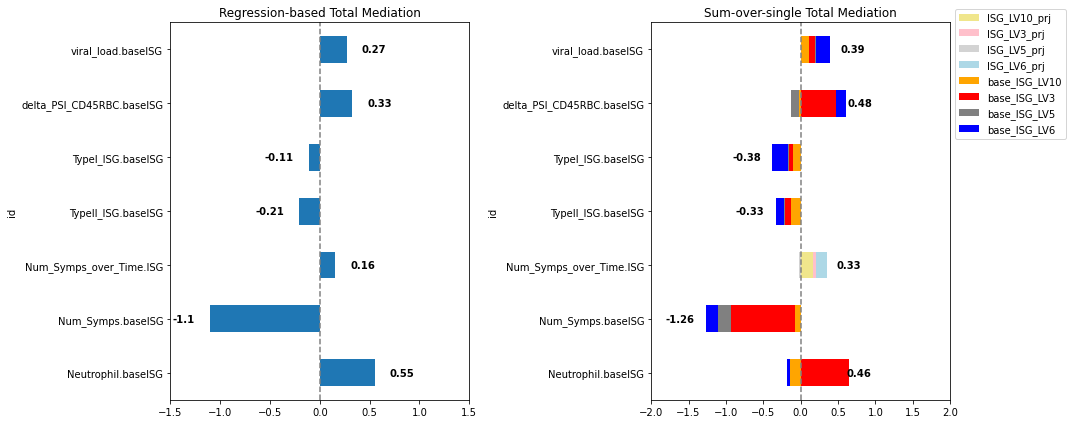

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15,6))
# Look at total effect with significant p-value 
ax = res_df.query('tot_pv<0.15').sort_values('id').plot.barh(x='id', y='med_prop', ax=axs[0])
for i, v in enumerate(res_df.query('tot_pv<0.15').sort_values('id')['med_prop']):
    ax.text(v+np.sign(v)*0.15, i, str(round(v,2)), ha='left' if v>0 else 'right', color='black', va='center', fontweight='bold')
ax.set_xlim(-2, 2)
ax.legend().remove()
ax.set_xlim(-1.5, 1.5)
ax.axvline(0, ls='--', color='gray')
ax.set_title('Regression-based Total Mediation')
# match with cma
a = cma.loc[cma.id.isin(res_df.query('tot_pv<0.15')['id'])].pivot(index='id', values='prop', columns='mediator')
ax = a.plot.barh(stacked=True, ax=axs[1], 
                 color=[
                     "khaki", 
                     "pink", 
                     "lightgrey", 
                     "lightblue", 
                     "orange", 
                     "red", 
                     "grey", 
                     "blue", 
                 ]
                )
for i, v in enumerate(cma.loc[cma.id.isin(res_df.query('tot_pv<0.15')['id'])][['id', 'prop']].groupby('id').sum()['prop']):
    ax.text(v+np.sign(v)*0.15, i, str(round(v,2)), ha='left' if v>0 else 'right', va='center', color='black', fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_xlim(-2, 2)
ax.axvline(0, ls='--', color='gray')
ax.set_title('Sum-over-single Total Mediation')


fig.tight_layout()
fig.savefig("data-V9/mediation_analysis/total_mediation.pdf")